### Importing all the necessary data 

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

### Reading in the files

In [3]:
X=pd.read_csv("../data/Genes/data.csv")

In [4]:
y=pd.read_csv("../data/Genes/labels.csv")

### EDA

In [5]:
X.shape

(801, 20532)

In [6]:
y.shape

(801, 2)

#### Y has a column which we will never use so lets remove it 

In [7]:
y=y.iloc[:,1]

#### Checking all the unique values that we have to cluster the given data in 

In [8]:
y.value_counts()

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class', ylabel='Count'>

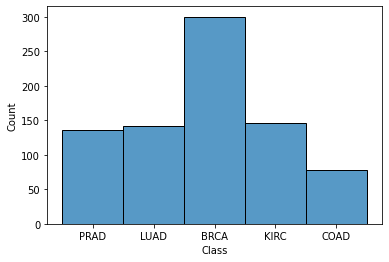

In [9]:
sns.histplot(y)

#### We have a healthy ratio of samples where we can see that even though BRCA dominates we can see other labels are plentifully present

#### Eventhough we dont have a heavy class imbalance we might later use SMOTE to create some artificial samples

#### Examining X

In [10]:
X=X.iloc[:,1:]

In [11]:
np.flatnonzero(X.dtypes!="float64")


array([], dtype=int64)

#### all the columns consist of floating numbers

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20531 entries, gene_0 to gene_20530
dtypes: float64(20531)
memory usage: 125.5 MB


#### Checking for any null values

In [13]:
np.flatnonzero(np.sum(pd.isnull(X))>0)

array([], dtype=int64)

#### We find that there are no null values 

### Splittng the dataset into 80% and 20% so that we have train and test sets

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.20, random_state=42,stratify=y)

In [38]:
X_train.shape

(640, 20531)

In [39]:
X_test.shape

(161, 20531)

In [40]:
np.unique(y_train,return_counts=True)

(array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object),
 array([240,  62, 116, 113, 109], dtype=int64))

In [41]:
np.unique(y_test,return_counts=True)

(array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object),
 array([60, 16, 30, 28, 27], dtype=int64))

#### We see that by using stratify we preserve the  ratio of samples that we have in test and train sets 

In [42]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [43]:
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())
])

In [44]:
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OrdinalEncoder())
])

#### All are features are numerical and we have no categorical variables.

In [45]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

In [46]:
categorical_features = X.select_dtypes(include=['object']).columns

In [47]:
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,#('categorical', categorical_transformer, categorical_features)
]) 

In [48]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [78]:
pca = PCA(n_components=0.95)

In [79]:
knn=KNeighborsClassifier(n_neighbors=3)

In [80]:
rf=RandomForestClassifier()

In [81]:
pp1 = Pipeline(steps = [
               ('preprocessor', preprocessor),
                ('pca',pca),
                ('knn',knn)
           ])

In [82]:
pp2=Pipeline(steps = [
               ('preprocessor', preprocessor),
                ('pca',pca),
                ('rf',rf)
           ])

In [83]:
param_grid_pp1 = {
    "pca__n_components": [0.90,0.95],
    "knn__n_neighbors": [3,5,7,9,11,15,17],
    #"knn__weights":["uniform", "distance"]
}

In [84]:
#from sklearn.model_selection import GridSearchCV

In [66]:
#search_pp1 = GridSearchCV(pp1, param_grid_pp1)

In [67]:
#search_pp1.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5', 'gene_6',
       'gene_7', 'gene_8', 'gene_9',
       ...
       'gene_20521', 'gene_20522', 'gene_20523', 'gene_20524', 'gene_20525',
       'gene_20526', 'gene_20527', 'gene_20528', 'gene_20529', 'gene_20530'],
      dtype='object', length=20531))])),
                                       ('pca',

In [68]:
#print("Best parameter (CV score=%0.3f):" % search_pp1.best_score_)
#print(search_pp1.best_params_)

Best parameter (CV score=0.998):
{'knn__n_neighbors': 3, 'pca__n_components': 0.95}


In [86]:
knn_model=pp1.fit(X_train,y_train)

In [88]:
pred=knn_model.predict(X_test)

In [89]:
from sklearn.metrics import classification_report

In [90]:
target_names=np.unique(y)

In [91]:
print(classification_report(y_test, pred, target_names=target_names))

              precision    recall  f1-score   support

        BRCA       0.97      1.00      0.98        60
        COAD       1.00      1.00      1.00        16
        KIRC       1.00      0.97      0.98        30
        LUAD       1.00      0.93      0.96        28
        PRAD       0.96      1.00      0.98        27

    accuracy                           0.98       161
   macro avg       0.99      0.98      0.98       161
weighted avg       0.98      0.98      0.98       161



In [93]:
rf_model=pp2.fit(X_train,y_train)

In [96]:
pred2=rf_model.predict(X_test)

In [97]:
print(classification_report(y_test, pred2, target_names=target_names))

              precision    recall  f1-score   support

        BRCA       0.82      1.00      0.90        60
        COAD       1.00      0.81      0.90        16
        KIRC       1.00      0.97      0.98        30
        LUAD       1.00      0.68      0.81        28
        PRAD       0.96      0.96      0.96        27

    accuracy                           0.91       161
   macro avg       0.96      0.88      0.91       161
weighted avg       0.93      0.91      0.91       161

